# Image Processing and Intensity Profile Analysis

## Introduction

This document provides a detailed explanation of the image processing code. The code enhances an image using various techniques, calculates clarity metrics, and plots the intensity profiles along specified lines.

## 1.Importing Libraries


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import shannon_entropy
from google.colab.patches import cv2_imshow
import time
# from google.colab import files

## 2.Defining Clarity Metrics Functions

Three functions are defined to calculate image clarity metrics:

In [ ]:
def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

def tenengrad(image):
    gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    return np.sqrt(gx**2 + gy**2).mean()

def entropy(image):
    return shannon_entropy(image)

variance_of_laplacian: Measures the focus of the image.

tenengrad: Measures the gradient magnitude.

entropy: Measures the randomness or complexity of the image.

## 3.Getting Line Coordinates

A function is defined to get the coordinates for a specific line based on the image name:

In [ ]:
def get_line_coordinates(image_name):
    if image_name == '1.jpg':
        return (265, 2032), (1364, 2089)
    elif image_name == '2.jpg':
        return (1146, 1508), (1402, 1776)
    elif image_name == '3.jpg':
        return (1483, 2522), (1899, 2522)
    elif image_name == 'RBC_whole.jpg':
        return (3383, 3108),(3383, 3495)
    elif image_name == 'USAF_whole.jpg':
        return (2490, 3532),(2490, 3977)
    elif image_name == 'grid_whole.jpg':
        return (3015, 2577),(3015, 5239)
    else:
        raise ValueError(f"Unsupported image name: {image_name}")

## 4.Loading the Image

The code loads the image specified by the path:

In [ ]:
## Define image to load

# 'USAF' or 'RBC' or 'grid'

image_prefix = 'RBC'

In [ ]:
# image_path = 'images/2.jpg'
# image_name = image_path.split('/')[-1]
image_path = image_prefix+'_whole.jpg'
image_name = image_path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError(f"Image not found at the path: {image_path}")

start_time = time.time()

In [ ]:
if image_prefix == 'USAF':
  # for USAF only
  center = (2971,3904)
  radius = 1177
elif image_prefix == 'RBC':
  # for cell
  center = (2978,3785)
  radius = 1384
elif image_prefix == 'grid':
  # for grid
  center = (3056,3881)
  radius = 1370
else:
  raise ValueError(f"Unsupported image prefix: {image_prefix}")

Purpose: Define the center and radius for creating a circular mask based on the image type. This helps in focusing on a specific region of interest.

## 4.1 Creating and Applying the Circular Mask:

In [ ]:
color = (255, 255 , 255)
thickness = -1
new_image = cv2.circle(np.zeros_like(image), center, radius, color, thickness).astype("uint8")
new_image[new_image!=0]=image[new_image!=0]

filename = image_prefix + '_new.png'
cv2.imwrite(filename,new_image)
# files.download(filename)

True

Purpose: Create a circular mask to isolate the region of interest. This mask is then applied to the original image to focus on the specific area, reducing noise from irrelevant parts of the image.

## 4.2 Normalizing the Image Based on a Center Area:

In [ ]:
bright_img = image[3092:4736, 2167:3811]
max_px = np.amax(bright_img)
min_px = np.amin(bright_img)
minmax_img = np.array(image, dtype=np.uint8)
minmax_img[minmax_img > max_px] = max_px
minmax_img[minmax_img < min_px] = min_px
rescale_img = (minmax_img - min_px) / (max_px - min_px) * 255
rescale_img = np.array(rescale_img, dtype=np.uint8)
rescale_image = cv2.circle(np.zeros_like(rescale_img), center, radius, color, thickness).astype("uint8")
rescale_image[rescale_image != 0] = rescale_img[rescale_image != 0]


Purpose: Normalize the image based on the intensity range in a specified center area. This ensures consistent intensity levels across the image and mitigates the effects of varying lighting conditions.

In [ ]:
filename = image_prefix + '_rescale.png'
cv2.imwrite(filename,rescale_image)

True

## 5. Extracting Intensity Profile for Reference:

In [ ]:
(x1, y1), (x2, y2) = get_line_coordinates(image_name)
num_points = max(abs(x2 - x1), abs(y2 - y1)) + 1
x_values = np.linspace(x1, x2, num_points, dtype=int)
y_values = np.linspace(y1, y2, num_points, dtype=int)
intensity_profile_ref = rescale_image[y_values, x_values]

Purpose: Extract the intensity profile along a specific line in the image. This profile is used as a reference to compare against processed images.

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 16.8953218460083 seconds ---


## 6. Gaussian Blurring:

In [ ]:
blurred = cv2.GaussianBlur(rescale_image, (5, 5), 0)

Purpose: Blurring reduces high-frequency noise in the image, which is crucial before applying sharpening filters. If we sharpen the image without blurring first, the noise would also get amplified, leading to a less clear image.

In [ ]:
filename = image_prefix + '_1_blurred.png'
cv2.imwrite(filename,blurred)

True

## 7. Sharpening the Image:

In [ ]:
sharpening_kernel = np.array([[-1, -1, -1],
                              [-1, 9, -1],
                              [-1, -1, -1]])
sharpened = cv2.filter2D(blurred, -1, sharpening_kernel)


Purpose: Sharpen the blurred image to enhance edges and fine details. This step compensates for the blurring by highlighting important features in the image.

In [ ]:
filename = image_prefix + '_2_sharpened.png'
cv2.imwrite(filename,sharpened)

True

## 8. Median Filtering:

In [ ]:
median_filtered = cv2.medianBlur(sharpened, 5)

Purpose: Apply median filtering to reduce noise further. This step is particularly effective at removing salt-and-pepper noise while preserving edges.

In [ ]:
filename = image_prefix + '_3_medfiltered.png'
cv2.imwrite(filename,median_filtered)

True

## 9. Contrast Limited Adaptive Histogram Equalization (CLAHE):

In [ ]:
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
equalized = clahe.apply(median_filtered)


Purpose: Enhance the contrast of the image using CLAHE. This method improves the visibility of features by adjusting the histogram of local regions, preventing over-amplification of noise.

In [ ]:
filename = image_prefix + '_4_equalized.png'
cv2.imwrite(filename,equalized)

True

## 10. Brightness and Contrast Adjustment:

In [ ]:
alpha = 1.02  # Slight contrast increase
beta = 7      # Reduced brightness increase
brightened = cv2.convertScaleAbs(equalized, alpha=alpha, beta=beta)


Purpose: Adjust the brightness and contrast of the image to make features more discernible. The parameters are chosen to avoid overexposure.

In [ ]:
filename = image_prefix + '_5_brightened.png'
cv2.imwrite(filename,brightened)

True

## 11. Final Sharpening:

In [ ]:
kernel = np.array([[0, -0.5, 0],
                   [-0.5, 3, -0.5],
                   [0, -0.5, 0]])
final_image = cv2.filter2D(brightened, -1, kernel)


Purpose: The final sharpening step further enhances edges and fine details after the brightness and contrast adjustments. This ensures that the image is as clear and detailed as possible for analysis.

In [ ]:
filename = image_prefix + '_6_final.png'
cv2.imwrite(filename,final_image)

True

In [ ]:
max_final = np.amax(final_image)
min_final = np.amin(final_image)
print('Max pixel value of final_image is: ',max_final)
print('Min pixel value of final_image is: ',min_final)

Max pixel value of final_image is:  255
Min pixel value of final_image is:  0


## 12.Selecting Lines for Intensity Profile

a. Horizontal Line: Fixed at y-coordinate 100.

In [ ]:
(x1, y1), (x2, y2) = get_line_coordinates(image_name)
num_points = max(abs(x2 - x1), abs(y2 - y1)) + 1
x_values = np.linspace(x1, x2, num_points, dtype=int)
y_values = np.linspace(y1, y2, num_points, dtype=int)
intensity_profile_line = new_image[y_values, x_values]

b. Diagonal Line: From bright to dark areas based on coordinates.

In [ ]:
intensity_profile_slope = final_image[y_values, x_values]

## 13.Calculating Clarity Metrics

Clarity metrics are calculated for both the original and enhanced images:

In [ ]:
original_laplacian_var = variance_of_laplacian(new_image)
original_tenengrad_value = tenengrad(new_image)
original_entropy_value = entropy(new_image)

enhanced_laplacian_var = variance_of_laplacian(final_image)
enhanced_tenengrad_value = tenengrad(final_image)
enhanced_entropy_value = entropy(final_image)

reference_laplacian_var = variance_of_laplacian(rescale_image)
reference_tenengrad_value = tenengrad(rescale_image)
reference_entropy_value = entropy(rescale_image)

## 14.Displaying Images and Intensity Profiles

The original and enhanced images are displayed side by side, with the selected lines highlighted. Intensity profiles are plotted for both lines:

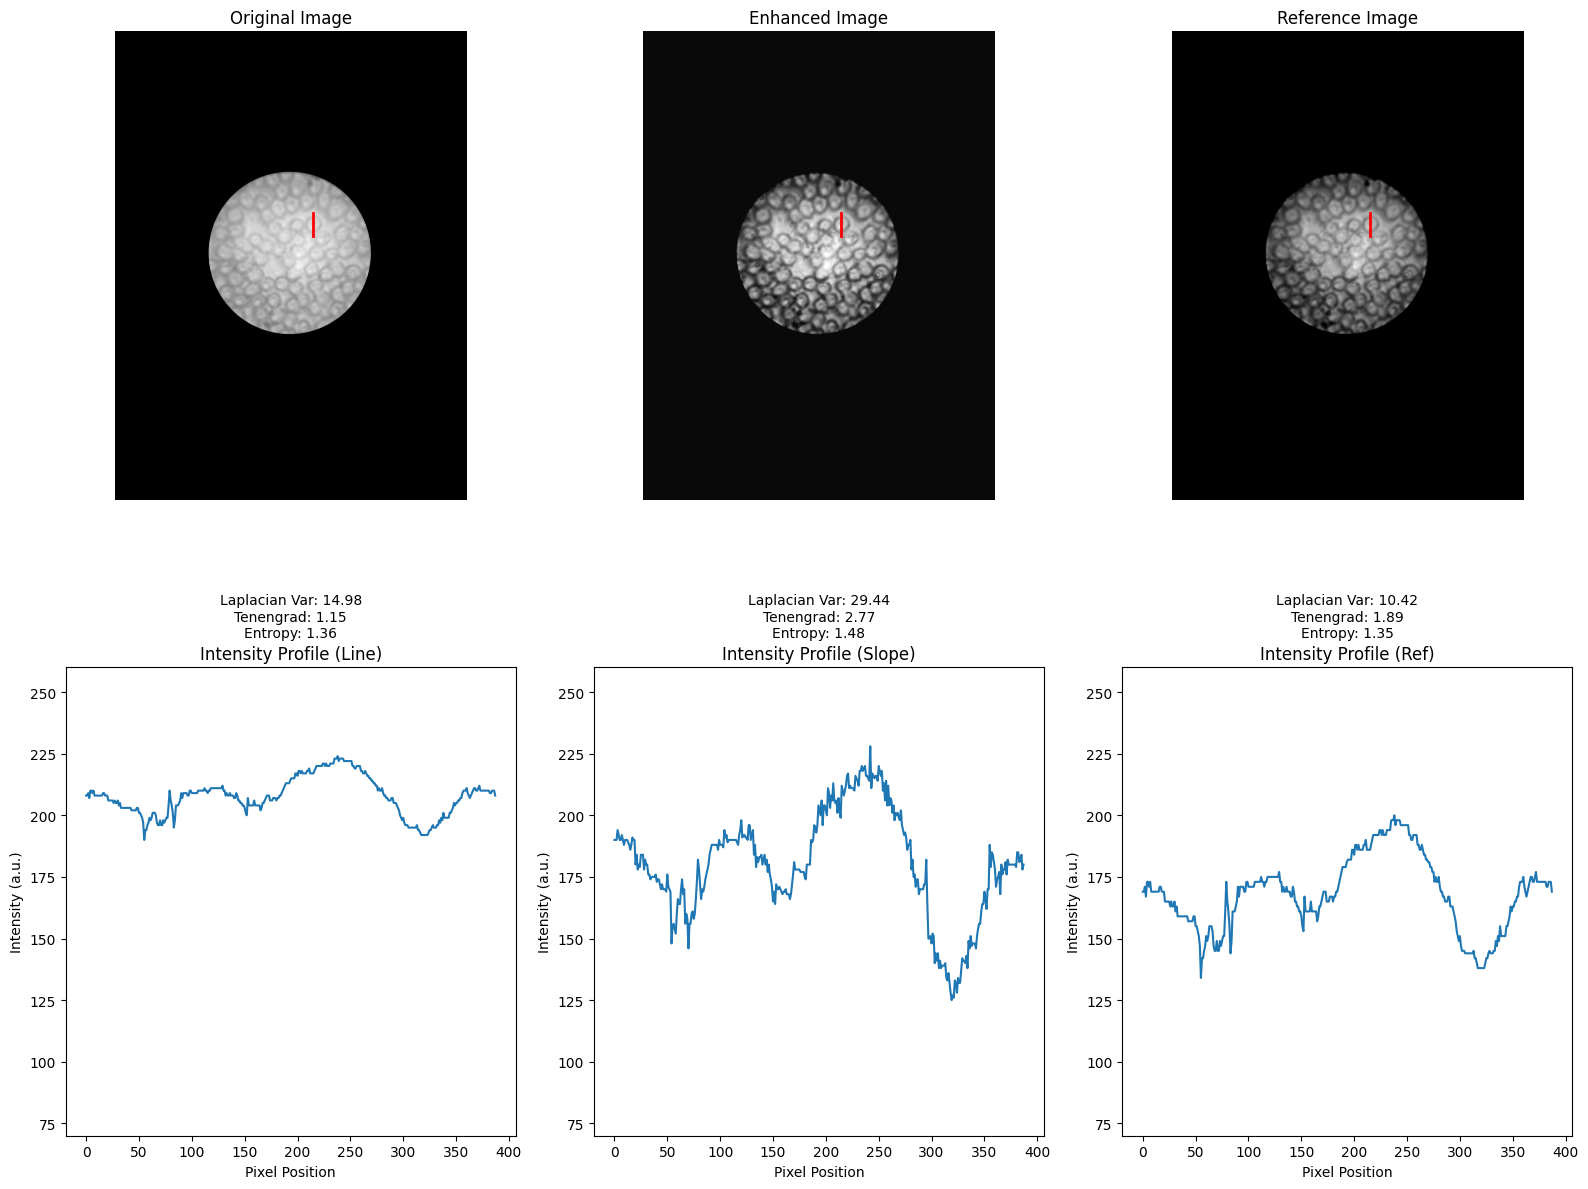

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 12))

# Plot original image and highlight the line
axes[0, 0].imshow(new_image, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')
axes[0, 0].plot([x1, x2], [y1, y2], color='red', linestyle='-', linewidth=2)
axes[0, 0].text(0.5, -0.2, f'Laplacian Var: {original_laplacian_var:.2f}\nTenengrad: {original_tenengrad_value:.2f}\nEntropy: {original_entropy_value:.2f}',
                ha='center', va='top', transform=axes[0, 0].transAxes, fontsize=10)

# Plot enhanced image and highlight the line
axes[0, 1].imshow(final_image, cmap='gray')
axes[0, 1].set_title('Enhanced Image')
axes[0, 1].axis('off')
axes[0, 1].plot([x1, x2], [y1, y2], color='red', linestyle='-', linewidth=2)
axes[0, 1].text(0.5, -0.2, f'Laplacian Var: {enhanced_laplacian_var:.2f}\nTenengrad: {enhanced_tenengrad_value:.2f}\nEntropy: {enhanced_entropy_value:.2f}',
                ha='center', va='top', transform=axes[0, 1].transAxes, fontsize=10)

# Plot reference image and highlight the line
axes[0, 2].imshow(rescale_image, cmap='gray')
axes[0, 2].set_title('Reference Image')
axes[0, 2].axis('off')
axes[0, 2].plot([x1, x2], [y1, y2], color='red', linestyle='-', linewidth=2)
axes[0, 2].text(0.5, -0.2, f'Laplacian Var: {reference_laplacian_var:.2f}\nTenengrad: {reference_tenengrad_value:.2f}\nEntropy: {reference_entropy_value:.2f}',
                ha='center', va='top', transform=axes[0, 2].transAxes, fontsize=10)

# Plot the intensity profiles
axes[1, 0].plot(np.linspace(0, len(intensity_profile_line) - 1, len(intensity_profile_line)), intensity_profile_line)
axes[1, 0].set_title('Intensity Profile (Line)')
axes[1, 0].set_xlabel('Pixel Position')
axes[1, 0].set_ylabel('Intensity (a.u.)')
axes[1, 0].axis(ymin=70,ymax=260)

axes[1, 1].plot(np.linspace(0, len(intensity_profile_slope) - 1, len(intensity_profile_slope)), intensity_profile_slope)
axes[1, 1].set_title('Intensity Profile (Slope)')
axes[1, 1].set_xlabel('Pixel Position')
axes[1, 1].set_ylabel('Intensity (a.u.)')
axes[1, 1].axis(ymin=70,ymax=260)

axes[1, 2].plot(np.linspace(0, len(intensity_profile_ref) - 1, len(intensity_profile_ref)), intensity_profile_ref)
axes[1, 2].set_title('Intensity Profile (Ref)')
axes[1, 2].set_xlabel('Pixel Position')
axes[1, 2].set_ylabel('Intensity (a.u.)')
axes[1, 2].axis(ymin=70,ymax=260)

plt.tight_layout()
plt.show()